<a href="https://colab.research.google.com/github/truongvanhuy2000/DeepLearningProject/blob/main/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initialize

In [ ]:
pip install -U albumentations

In [ ]:
pip install opencv-python==4.5.5.64

In [ ]:
!cp '/content/drive/MyDrive/Deep-learning/Home.zip' '/content/'

In [ ]:
import zipfile
with zipfile.ZipFile('/content/Home.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
import os
import time
import uuid
import cv2

import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# 2. Review Dataset and Build Image Loading Function

In [ ]:
images = tf.data.Dataset.list_files('/content/Home/images/*.jpg', shuffle = True)

In [ ]:
images.as_numpy_iterator().next()

b'/content/Home/images/1b9c9971-0358-11ed-b210-8c1645577237.jpg'

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 3. Partition Unaugmented Data

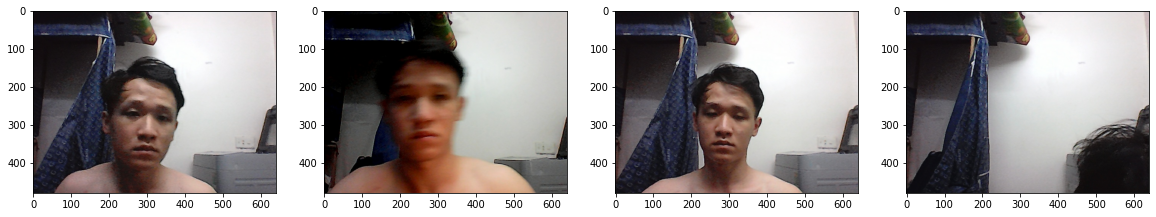

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [ ]:
import shutil
for folder in ['train','test','val']:
    for file in os.listdir('/content/Home/'+ folder + '/images/'):
        filename = file.split('.')[0]+'.json'
        existing_filepath = '/content/Home/label/' + filename
        if os.path.exists(existing_filepath): 
            new_filepath = '/content/Home/' + folder +'/label/'
            shutil.copy2(existing_filepath, new_filepath)

# 4. Test Albumentations

In [ ]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
img = cv2.imread('/content/Home/images/005398b7-0358-11ed-b816-8c1645577237.jpg')
with open('/content/Home/label/005398b7-0358-11ed-b816-8c1645577237.json', 'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]['points']

[[179.0, 140.0], [402.0, 413.0]]

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[179.0, 140.0, 402.0, 413.0]

In [ ]:
print(coords[2:])

[402.0, 413.0]


In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.2796875, 0.2916666666666667, 0.628125, 0.8604166666666667]

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes']

[(0.057777777777777775, 0.25333333333333335, 0.5533333333333333, 0.86)]

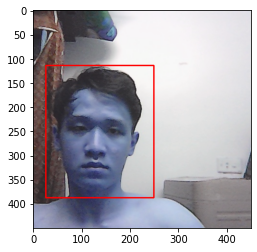

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])
#image will be blue because opencv render image as bgr and matplotlib render as rgb

# 5. Build and Run Augmentation Pipeline

In [ ]:
!rm -rf aug_data
!mkdir aug_data
!mkdir aug_data/val
!mkdir aug_data/train/
!mkdir aug_data/test
!mkdir aug_data/test/images
!mkdir aug_data/test/label
!mkdir aug_data/train/images
!mkdir aug_data/train/label
!mkdir aug_data/val/images
!mkdir aug_data/val/label

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir('/content/Home/'+ partition + '/images/'):
        img = cv2.imread('/content/Home/'+ partition + '/images/' + image)

        coords = [0,0,0.00001,0.00001]
        jsonFile = image.split('.')[0]+'.json'
        label_path = '/content/Home/'+ partition + '/label/' + jsonFile
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite('/content/aug_data/'+ partition + '/images/' + f'{image.split(".")[0]}.{x}.jpg', augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open('/content/aug_data/'+ partition + '/label/' + f'{image.split(".")[0]}.{x}.json', 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.19375, 0.44166666666666665, 0.0, 0.9958333333333333, 'face'].
x_max is less than or equal to x_min for bbox [0.2984375, 0.2625, 0.0, 0.9708333333333333, 'face'].
x_max is less than or equal to x_min for bbox [0.3421875, 0.26666666666666666, 0.0078125, 0.9979166666666667, 'face'].
x_max is less than or equal to x_min for bbox [0.2703125, 0.33541666666666664, 0.0, 0.9916666666666667, 'face'].
x_max is less than or equal to x_min for bbox [0.26875, 0.38125, 0.0125, 0.9979166666666667, 'face'].
x_max is less than or equal to x_min for bbox [0.3546875, 0.30833333333333335, 0.0, 0.9916666666666667, 'face'].
x_max is less than or equal to x_min for bbox [0.3109375, 0.26875, 0.0, 0.95625, 'face'].
x_max is less than or equal to x_min for bbox [0.1703125, 0.475, 0.0, 0.9708333333333333, 'face'].
x_max is less than or equal to x_min for bbox [0.39375, 0.3020833333333333, 0.01875, 0.9520833333333333, 'face'].
x_max is less than or equal to x_min fo

In [ ]:
train_images = tf.data.Dataset.list_files('/content/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

# 6. Prepare Labels

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/aug_data/train/label/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/aug_data/test/label/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/aug_data/val/label/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1777, 0.1622, 0.7334, 0.8047], dtype=float16))

# 7. Combine Label and Image Samples

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7020, 7020, 1500, 1500, 1680, 1680)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(10000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


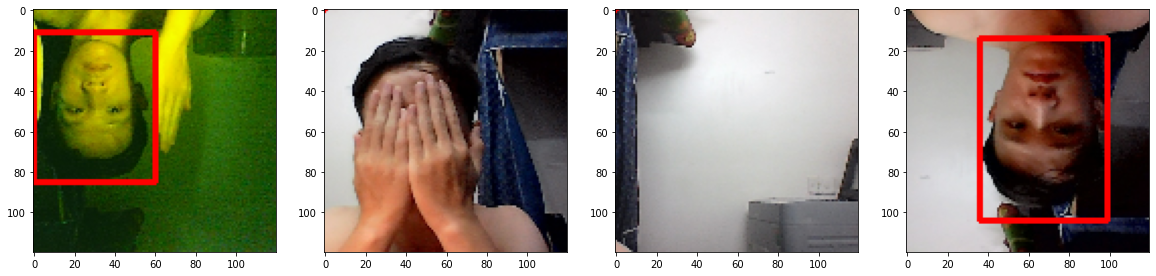

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16


from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dropout(0.2)(class1)
    class3 = Dense(1, activation='sigmoid')(class2)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dropout(0.2)(regress1)
    regress3 = Dense(4, activation='sigmoid')(regress2)
    
    facetracker = Model(inputs=input_layer, outputs=[class3, regress3])
    return facetracker

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_13[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

# 9. Define Losses and Optimizers

In [ ]:
len(train)

878

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [ ]:
!mkdir 'logs'

In [ ]:
logdir='/content/logs/'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
878/878 [==============================] - 89s 70ms/step - total_loss: 0.3630 - class_loss: 0.0950 - regress_loss: 0.3155 - val_total_loss: 0.0517 - val_class_loss: 0.0014 - val_regress_loss: 0.0511


KeyboardInterrupt: ignored

In [ ]:
hist.history

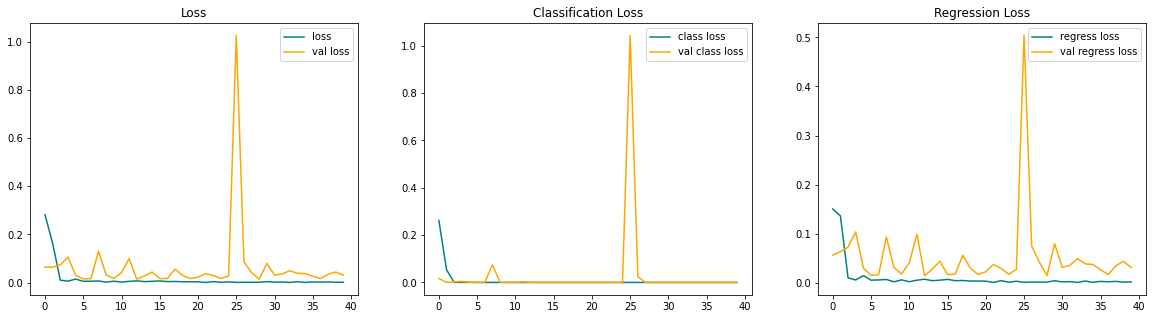

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


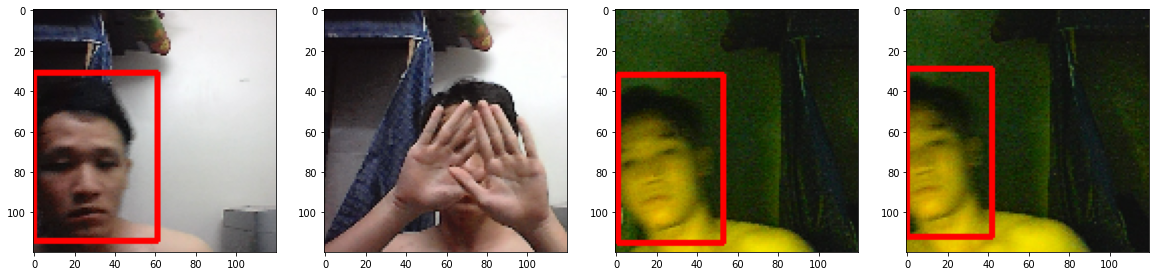

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('/content/drive/MyDrive/facetrackerHome.h5')

In [ ]:

facetracker = load_model('facetracker.h5')

OSError: ignored